In [1]:
## yikes idk how you would do this anymore
import sys 
sys.path.insert(0, '../')

%load_ext autoreload
%aimport processing, basket, coin, VirtMart

In [2]:
%autoreload 1

import pandas as pd
import numpy as np

import datetime
from datetime import timezone
import pytz
import random

from pycoingecko import CoinGeckoAPI

from processing import Processor
from basket import Basket
from coin import Coin
from CGProcessor import CGProcessor
from bin import Statistics, Tests, Transforms

import statsmodels.tsa.stattools as ts 

In [3]:
# coin_list = cg.get_coins_list()

# ids = [coin_data['id'] for coin_data in coin_list]

# id_to_data = {}
# for coin_data in coin_list:
#     id_to_data[coin_data.pop('id')] = coin_data
# ids = id_to_data.keys()

In [4]:
# COIN_COLS = ['id', 'symbol', 'name']
# df_coin_names = pd.DataFrame(coin_list, columns=['name'])

# coin_market = cg.get_coins_markets(vs_currency=NAT_CURR)
# df_market = pd.DataFrame(coin_market, columns=['id', 'current_price', 'high_24h', 'low_24h'])
# df_market.set_index('id', inplace=True)

In [5]:
###############
## CONSTANTS ##
###############

NAT_TZ = 'America/Los_Angeles'
NAT_TZOBJ = pytz.timezone(NAT_TZ)

TRG_TZOBJ = timezone.utc

PORT_IDS = ['bitcoin', 'bitcoin-cash', 'ethereum', 'litecoin']
start_date, end_date = (2020,1,1), (2021,10,31)

NAT_CURR = 'usd'

LOOKBACKS = [7, 14, 30]
ROLL_WIND = LOOKBACKS[1]

In [6]:
##################
## LOCAL DRIVER ##
##################

cgp = CGProcessor()

# Create portfolio dataframe
port_val = cgp.create_portfolio(PORT_IDS, start_date, end_date)
data = cgp.data

cgp.normalize([], port=True)

In [7]:
display(data)

,bitcoin,bitcoin-cash,ethereum,litecoin
1577836800000,7195.153895,204.561792,129.186385,41.330312
1577923200000,7193.754668,204.348311,130.484685,41.606316
1578009600000,6963.853354,195.674640,127.045258,39.413813
1578096000000,7300.346935,221.621452,133.702649,41.991047
1578182400000,7351.377053,224.487505,134.136883,42.781417
...,...,...,...,...
1635292800000,60604.188888,609.848740,4152.570289,198.406010
1635379200000,58641.001474,551.244177,3944.090862,180.241936
1635465600000,60767.555852,579.019616,4288.097219,190.168430
1635552000000,62283.198056,591.975602,4422.940536,196.704274


# Tests
Test cointegration of coin basket: {coins} = {c_1,...,c_n}
ie. Check that the set {coins} is cointegrated using Engle-Granger two-step test
This means there is some STATIONARY linear combination of {coins}

<ol>
    <li>Check that c_i is order-1 integrable</li>
    <li>Create basket of coins, find linear regression.</li>
    <li>Verify spread of basket is cointegrated.</li>
    <li>Define strategy for basket trades.</li>
</ol>

#### Concerns
<ul>
    <li>Should we normalize data before running our regression?</li>
</ul>

#### Conclusions
<ul>
    <li>OLS and Linear Regression yield the same coefficients</li>
    <li>While we usually assume stock data is I(1), it sometimes isn't (eg. Litecoin, BTC-Cash)</li>
    <li>Normalization might help us find a regression line that does cointegrate the portfolio</li>
    <li>We should run this test on different coins in different sized baskets.</li>
</ul>

Verifying coin price stationarity...
['bitcoin', 'bitcoin-cash', 'ethereum', 'litecoin']  are stationary 

Fitting linear_regression ...
Found coefficients for basket:  [1, -66.41456935145989, 6.317443097671282, 340.54675533260354]
At intercept:  8199.409989048654
Basket is valid, all coins are I(1).


Cointegration test returned: True


<Figure size 432x288 with 0 Axes>

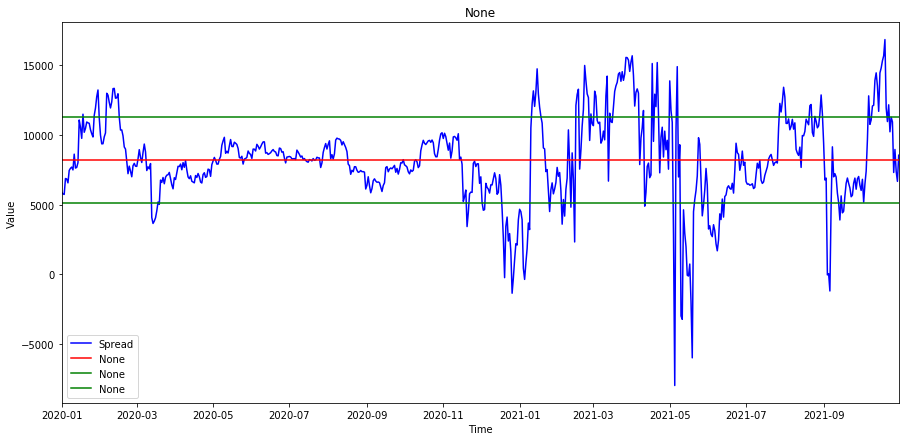

In [8]:
############
## TEST 1 ##
############

# print("Normalizing...")
# scaler = MinMaxScaler()
# scaler.fit(X, y)
# X_scaled = scaler.transform(X) # TODO: Finish normalization
# X_scaled = pd.DataFrame(X_scaled/X_scaled[0], index=X.index) 
# X_scaled.columns = X.columns

print("Verifying coin price stationarity...")
coins = []
for coin_name in data:
    coin = Coin(coin_name)
    result = coin.is_good(data[coin_name], start_date, end_date)
    if result:
        coins.append(coin)
    else:
        print(coin_name, "is not I(1)")

print([coin.name_ for coin in coins], " are stationary \n")
        
basket = Basket(coins, target='bitcoin', processor=cgp)
basket.fit(data)
spread = basket.find_spread(data)
is_cointegrated = basket.is_coint(spread)
print("\n")
print("Cointegration test returned:", is_cointegrated)

short_entry, long_entry = basket.strat(spread)

# Explore Exchanges on CoinGecko

In [9]:
exchanges = cgp.cg.get_exchanges_list()
print("There are", len(exchanges), "exchanges.")

by_24hr_vol = sorted(exchanges, key=lambda d: d['trade_volume_24h_btc'], reverse=True) 
print("Top 3 by 24 trading volume:", [exchange['id'] for exchange in by_24hr_vol[:3]])
by_trust_score = sorted(exchanges, key=lambda d: d['trust_score_rank'])
print("Top 3 by trust score:", [exchange['id'] for exchange in by_trust_score[:3]])

There are 100 exchanges.
Top 3 by 24 trading volume: ['binance', 'gdax', 'okex']
Top 3 by trust score: ['binance', 'gdax', 'huobi']


For now just use the highest 100 market cap coins on coingecko

In [10]:
COLS = ['id', 'current_price', 'high_24h', 'low_24h', 'market_cap', 'total_volume']

coin_market = cgp.cg.get_coins_markets(vs_currency=NAT_CURR)
df_market = pd.DataFrame(coin_market, columns=COLS)
df_market.set_index('id', inplace=True)

In [11]:
df_market

,current_price,high_24h,low_24h,market_cap,total_volume
id,,,,,
bitcoin,62737.000000,63546.00,61587.000000,1183608940953,35884601586
ethereum,4578.590000,4674.90,4465.870000,541100561199,21641354347
binancecoin,559.740000,571.02,538.190000,94211024731,2343729583
solana,242.030000,245.69,222.840000,72689250501,5323159723
tether,1.000000,1.02,0.990444,72379207540,82031222817
...,...,...,...,...,...
decred,110.800000,114.82,109.610000,1490719023,10484151
icon,2.200000,2.35,2.190000,1482353121,92423705
kucoin-shares,19.240000,19.54,18.400000,1480246984,33414920


From binomial theorem there are $2^{100}$ baskets so we need to find a way of filtering.

<b>There are also too many coins to pull all of them at once! We might have to create and host a database that contains updated data. We can pull around 50 or so coins at once.</b>

### Strategy
Take Pearson (Spearman?) correlation of dataframe to filter out some coins.

Idea:
We could train a model to take price data and try to spit out which coins are the most likely to be cointegrated. I think this could be some kind of 

In [12]:
%%time
# Create portfolio dataframe
port_val = cgp.create_portfolio(df_market[:50].index, start_date, end_date)
data = cgp.data
# TODO: Write to CSV
data

CPU times: user 619 ms, sys: 72.3 ms, total: 691 ms
Wall time: 16.8 s


In [13]:
corr = data.corr()
corr

,bitcoin,ethereum,binancecoin,solana,tether,cardano,ripple,polkadot,dogecoin,usd-coin,...,tezos,the-graph,monero,eos,pancakeswap-token,thorchain,klay-token,aave,flow,kusama
bitcoin,1.000000,0.899123,0.878207,0.629661,0.265496,0.847127,0.819568,0.963216,0.698792,0.233591,...,0.787579,0.881568,0.914227,0.682623,0.842050,0.848916,0.862650,0.920606,0.845653,0.913100
ethereum,0.899123,1.000000,0.946117,0.813655,0.238686,0.963128,0.905904,0.888398,0.881139,0.239856,...,0.807413,0.678033,0.915737,0.730628,0.910541,0.906301,0.720760,0.879152,0.708518,0.908081
binancecoin,0.878207,0.946117,1.000000,0.712054,0.219670,0.921874,0.949915,0.894185,0.906667,0.240536,...,0.805964,0.736031,0.951978,0.816919,0.985140,0.960713,0.807686,0.870759,0.815168,0.936327
solana,0.629661,0.813655,0.712054,1.000000,0.200576,0.830565,0.692815,0.667566,0.621866,0.222027,...,0.767081,0.339892,0.597963,0.414516,0.657673,0.622278,0.426753,0.525312,0.414060,0.657683
tether,0.265496,0.238686,0.219670,0.200576,1.000000,0.239962,0.143786,0.232864,0.162212,0.235712,...,0.167672,0.209068,0.212250,0.059380,0.196245,0.161565,0.186535,0.204690,0.187494,0.213095
cardano,0.847127,0.963128,0.921874,0.830565,0.239962,1.000000,0.874346,0.851186,0.844869,0.267065,...,0.780408,0.648215,0.859583,0.675500,0.887366,0.856196,0.700144,0.840201,0.711144,0.892407
ripple,0.819568,0.905904,0.949915,0.692815,0.143786,0.874346,1.000000,0.831995,0.888178,0.175942,...,0.803314,0.659848,0.930199,0.840046,0.938491,0.943554,0.744133,0.818145,0.738873,0.885943
polkadot,0.963216,0.888398,0.894185,0.667566,0.232864,0.851186,0.831995,1.000000,0.712185,0.245987,...,0.850222,0.894641,0.894138,0.737770,0.865578,0.882230,0.875080,0.917107,0.864139,0.941046
dogecoin,0.698792,0.881139,0.906667,0.621866,0.162212,0.844869,0.888178,0.712185,1.000000,0.196327,...,0.647174,0.526770,0.869423,0.810022,0.905842,0.915491,0.601557,0.773437,0.590764,0.821049
usd-coin,0.233591,0.239856,0.240536,0.222027,0.235712,0.267065,0.175942,0.245987,0.196327,1.000000,...,0.166768,0.196614,0.213369,0.139039,0.216195,0.189335,0.179472,0.196453,0.168707,0.242892


In [14]:
print("Verifying coin price stationarity...")
coins = []
for coin_name in data:
    coin = Coin(coin_name)
    result = coin.is_good(data[coin_name], start_date, end_date)
    if result:
        coins.append(coin)
    else:
        print(coin_name, "is not I(1)")

data = data[[coin.name_ for coin in coins]]
print(list(data.columns), " are stationary \n")

Verifying coin price stationarity...
tether is not I(1)
usd-coin is not I(1)
binance-usd is not I(1)
dai is not I(1)
['bitcoin', 'ethereum', 'binancecoin', 'solana', 'cardano', 'ripple', 'polkadot', 'dogecoin', 'shiba-inu', 'terra-luna', 'avalanche-2', 'chainlink', 'wrapped-bitcoin', 'uniswap', 'litecoin', 'matic-network', 'algorand', 'bitcoin-cash', 'cosmos', 'stellar', 'vechain', 'axie-infinity', 'internet-computer', 'filecoin', 'tron', 'theta-token', 'ftx-token', 'compound-ether', 'ethereum-classic', 'fantom', 'crypto-com-chain', 'staked-ether', 'elrond-erd-2', 'okb', 'near', 'hedera-hashgraph', 'tezos', 'the-graph', 'monero', 'eos', 'pancakeswap-token', 'thorchain', 'klay-token', 'aave', 'flow', 'kusama']  are stationary 



In [62]:
def test(results, coin_set, data, start_date=start_date, end_date=end_date):
    try:
        cgp = CGProcessor()
        coin_names = [coin.name_ for coin in coin_set]

        print("Testing cointegration for", coin_names)

        # Create portfolio dataframe
        basket_data = data[coin_names]

        print("Verifying coin price stationarity... \n")
        coins = []
        for coin_name in basket_data:
            coin = Coin(coin_name)
            result = coin.is_good(basket_data[coin_name], start_date, end_date)
            if not result:
                print(coin_name, "is not I(1), scratching basket.")
                continue
            coins.append(coin)

        target = coin_names[0]
        basket = Basket(coins, target=target, processor=cgp)
        basket.fit(basket_data)
        spread = basket.find_spread(basket_data)
        is_cointegrated = basket.is_coint(spread)

        results = ts.coint(basket_data[target], basket_data.drop([target], axis=1), return_results=True)

        # Check that statsmodels cointegration test also passes
        t_stat = results[0]
        t_crit = results[2][0]

        print(t_stat, t_crit)         

        if t_stat >= t_crit:
            print("Did not pass statsmodels test.")
            is_cointegrated = False

        print("\n")
        print("Cointegration test returned:", is_cointegrated)

        if is_cointegrated:
            results.add(tuple([basket, results[0]]))
        
        return results
    
    except Exception as e:
        print(e)

In [69]:
# Fixed Random Sampler
# num_baskets = 10
# potential_sets = dict()

# for basket_size in range(2, 10):
#     print("Creating baskets of size", basket_size)
#     potential_sets_sample = set()
#     tries = 0
#     while len(potential_sets_sample) < num_baskets:
#         potential_sets_sample.add(tuple(sorted(random.sample(coins, basket_size))))
#         tries += 1
#     potential_sets[basket_size] = potential_sets_sample

# Monte Carlo for the boys
# For now just use it to find cointegrated baskets
# Goal: 
# 1) Randomly sample to find cointegrated basket
# 2) When you do, backtest it against some metric (like PnL)
# 3) Stash results
# 4) Use this to create profit expectation
def simulate(data, n_trials):
    basket_sizes = range(2, 7)
    cointegrated = dict()
    for i in basket_sizes:
        cointegrated[i] = set()
    display(cointegrated)
    for _ in range(n_trials):
        basket_size = random.sample(basket_sizes, 1)[0]
        coin_set = random.sample(coins, basket_size)
        cointegrated[basket_size] = test(cointegrated[basket_size], coin_set, data)
        display(cointegrated)
    display(cointegrated)
    return cointegrated

In [71]:
from IPython.utils import io

with io.capture_output() as captured:
    cointegrated = simulate(data, 100)

In [73]:
cointegrated

{2: set(),
 3: set(),
 4: {(Basket:[Coin: algorand, Coin: crypto-com-chain, Coin: uniswap, Coin: axie-infinity],
   -5.282742254253211),
  (Basket:[Coin: tron, Coin: klay-token, Coin: uniswap, Coin: ethereum-classic],
   -5.324826778112355)},
 5: {(Basket:[Coin: klay-token, Coin: tron, Coin: avalanche-2, Coin: ethereum-classic, Coin: axie-infinity],
   -5.036731427546306)},
 6: {(Basket:[Coin: avalanche-2, Coin: axie-infinity, Coin: ethereum-classic, Coin: uniswap, Coin: wrapped-bitcoin, Coin: klay-token],
   -5.44581710851319),
  (Basket:[Coin: tron, Coin: ethereum-classic, Coin: avalanche-2, Coin: klay-token, Coin: crypto-com-chain, Coin: algorand],
   -6.019213938341847)}}

Stat: -5.565416577047835
17


<Figure size 432x288 with 0 Axes>

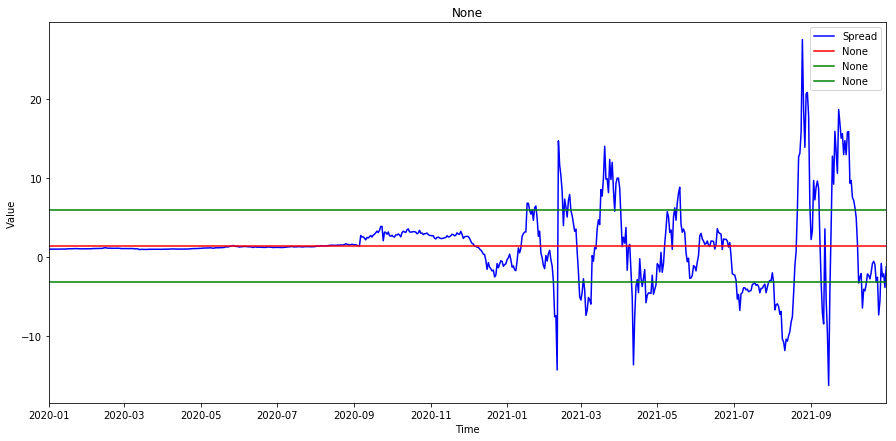

Stat: -5.03355906962009
3


<Figure size 432x288 with 0 Axes>

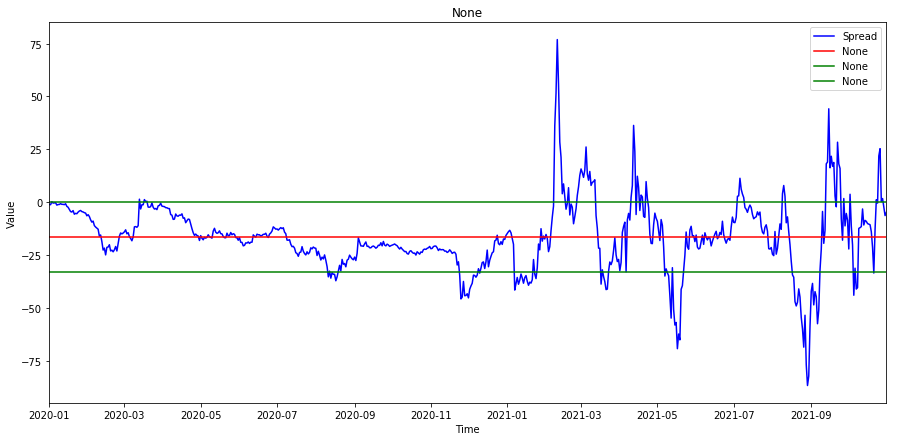

Stat: -5.507838858421728
17


<Figure size 432x288 with 0 Axes>

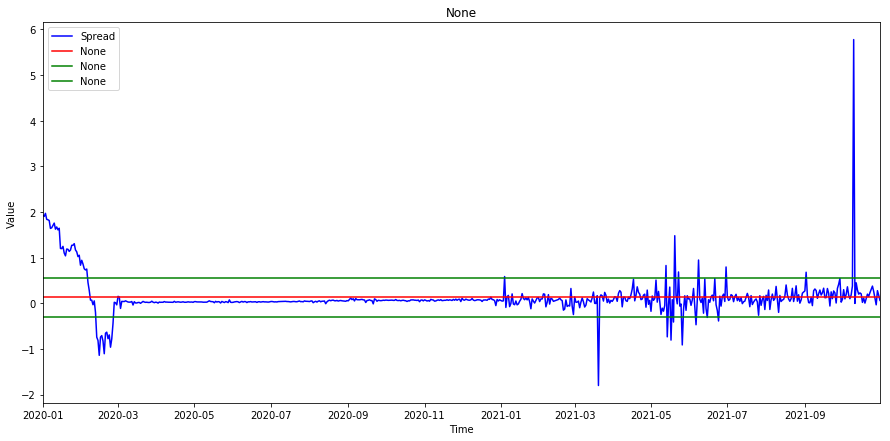

Stat: -5.407105581491333
7


<Figure size 432x288 with 0 Axes>

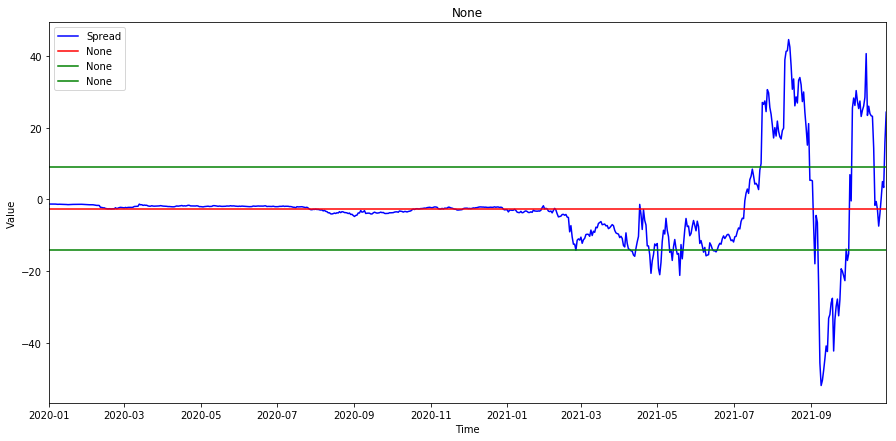

Stat: -5.904618452475366
56


<Figure size 432x288 with 0 Axes>

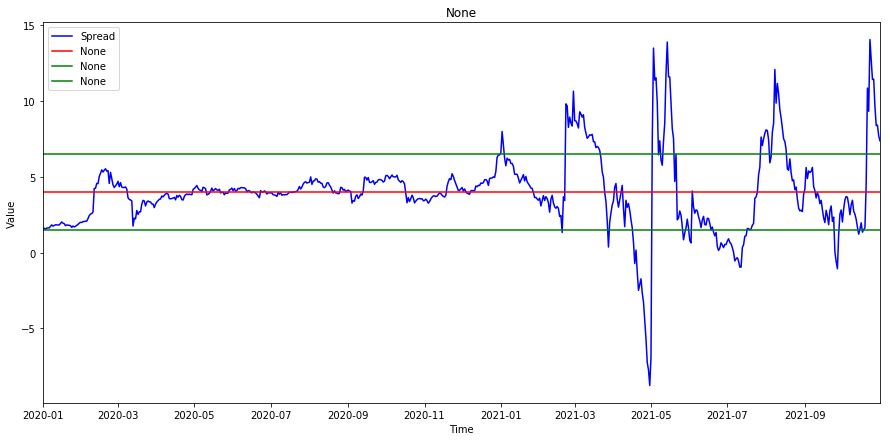

Stat: -4.615336310238362
33


<Figure size 432x288 with 0 Axes>

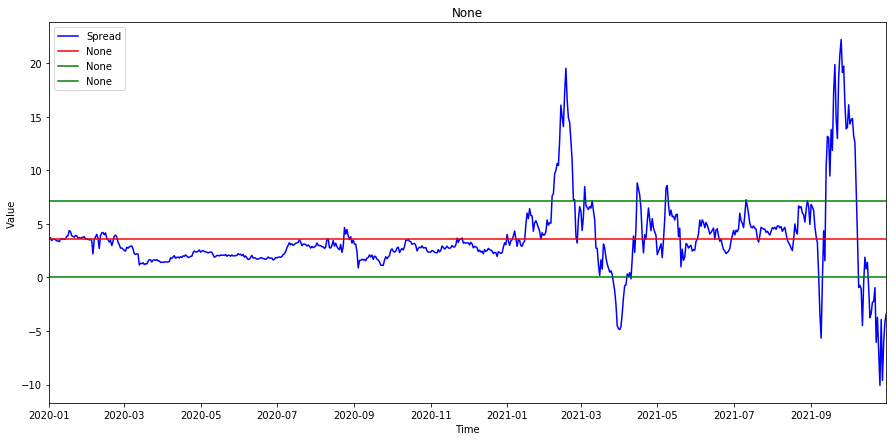

Stat: -4.733891947143142
11


<Figure size 432x288 with 0 Axes>

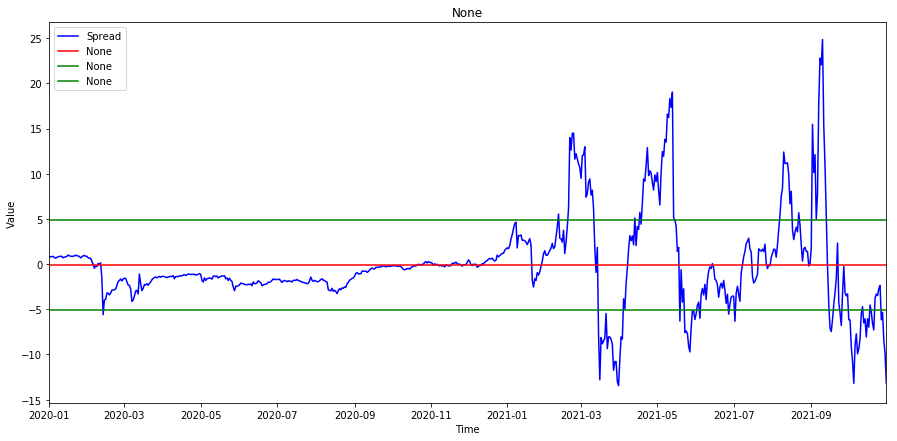

In [26]:
for basket in cointegrated:
    print("Stat:", basket[1])
    basket = basket[0]
    spread = basket.find_spread(data[[c.name_ for c in basket.coins_]])
    print(np.where(spread > 3*basket.std_, True, False).sum())
    basket.strat(spread)